# Image Similarity Analysis: Using VLAD and Fisher Vector Encoders

Welcome to the guide on using the `VLAD` and `FisherVector` encoders for image similarity analysis. Here, we will walk through the following steps:

1. Initializing an encoder (VLAD or Fisher Vector).
2. Training the encoder using the `learn` method.
3. Using pre-trained PCA and clustering models (KMeans/GMM), saving them, and loading them for reuse.
4. Encoding images and computing similarities.

## 1. Setting Up

Let's begin by importing the necessary modules and preparing our environment.

### Required Imports and Configuration

In [7]:
from itertools import islice

import numpy as np
import joblib
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from pyvisim.encoders import VLADEncoder, FisherVectorEncoder
from pyvisim.features import SIFT
from pyvisim.datasets import OxfordFlowerDataset
from pyvisim._utils import plot_image

## 2. Initializing an Encoder

### Example: Initializing a VLAD Encoder with RootSIFT Features

Since the default feature extractor for VLAD is RootSIFT, we can directly initialize the encoder without specifying the feature extractor.


In [8]:
# Initialize a VLAD encoder
vlad_encoder = VLADEncoder()
print("Feature extractor:", vlad_encoder.feature_extractor)

Feature extractor: RootSIFT(output_dim=128)



### Example: Initializing a Fisher Vector Encoder with SIFT Features


In [9]:
# Initialize a RootSIFT feature extractor
feature_extractor = SIFT()

# Initialize a Fisher Vector encoder
fisher_encoder = FisherVectorEncoder(feature_extractor=feature_extractor)


## 3. Training the Encoder Using the `learn` Method

The `learn` method trains the clustering model (KMeans for VLAD or GMM for Fisher Vector) and optionally applies PCA for dimensionality reduction.

### Example: Training a VLAD Encoder


In [10]:
# Load sample images from the Oxford Flower dataset
dataset = OxfordFlowerDataset()
images = [image for i, (image, *_) in enumerate(islice(dataset, 200))] # Set '200' to len(dataset) for full dataset

### Set number of clusters for KMeans or GMM

Set `k` lower if you run into runtime issues, but VLAD and Fisher Vector encoders benefit from a higher number of clusters.

In [11]:
k = 32

In [12]:
# Train the encoder with KMeans clustering
vlad_encoder.learn(images, n_clusters=k)

[INFO] Learning the visual vocabulary with the following parameters:
   - Number of clusters: 32
   - Feature Extractor used: RootSIFT
   - Dimension of the feature space: 128



### Example: Training a Fisher Vector Encoder


In [13]:
# Train the encoder with GMM clustering
fisher_encoder.learn(images, n_clusters=k)

[INFO] Learning the visual vocabulary with the following parameters:
   - Number of clusters: 32
   - Feature Extractor used: SIFT
   - Dimension of the feature space: 128


C:\Users\STUD_VuNhat\AppData\Local\anaconda3\envs\conda_env\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(



## 4. Using Pre-Trained Models (PCA and Clustering)

### Step 1: Train PCA and Clustering Models Separately

You can train PCA and clustering models (KMeans/GMM) independently and save them for later use.

#### Training and Saving PCA

Here, we will reduce the dimensionality of the features by half before training the clustering model.

In [14]:
# Flatten features from images
features = np.vstack([feature_extractor(image) for image in images])

# Train PCA
output_dim = feature_extractor.output_dim
pca = PCA(n_components=output_dim // 2)
pca.fit(features)

# Save PCA model
joblib.dump(pca, "pca_model.pkl")

['pca_model.pkl']

### IMPORTANT

Note that **the `PCA` model has to be trained first**, then `use the PCA model to transform the features`before and feed these into the clustering model, since PCA will reduce the dimensionality of the features (you will get dimension mismatch errors otherwise).

In [15]:
features_transformed = pca.transform(features)


#### Training and Saving KMeans/GMM


In [16]:
# Train KMeans
kmeans = KMeans(n_clusters=k)
kmeans.fit(features_transformed)

# Save KMeans model
joblib.dump(kmeans, "kmeans_model.pkl")

# Train GMM
gmm = GaussianMixture(n_components=k, covariance_type='diag')
gmm.fit(features_transformed)

# Save GMM model
joblib.dump(gmm, "gmm_model.pkl")

['gmm_model.pkl']

### Step 2: Loading Pre-Trained Models and Using Them

In [17]:
# Load PCA model
pca = joblib.load("pca_model.pkl")

# Load KMeans model
kmeans = joblib.load("kmeans_model.pkl")

# Initialize VLAD encoder with pre-trained KMeans
vlad_encoder = VLADEncoder(feature_extractor=feature_extractor, kmeans_model=kmeans, pca=pca)

# Load GMM model
gmm = joblib.load("gmm_model.pkl")

# Initialize Fisher Vector encoder with pre-trained GMM
fisher_encoder = FisherVectorEncoder(feature_extractor=feature_extractor, gmm_model=gmm, pca=pca)


## 5. Encoding Images and Computing Similarities

### Example: Encoding Images


In [18]:
image_encodings_vlad = vlad_encoder.encode(images)
print("Shape of VLAD encodings:", image_encodings_vlad.shape)

Shape of VLAD encodings: (200, 2048)


In [19]:
image_encodings_fisher = fisher_encoder.encode(images)
print("Shape of Fisher Vector encodings:", image_encodings_fisher.shape)

Shape of Fisher Vector encodings: (200, 4128)



### Example: Computing Similarity Between Two Images

First, we choose and plot the images to compare.

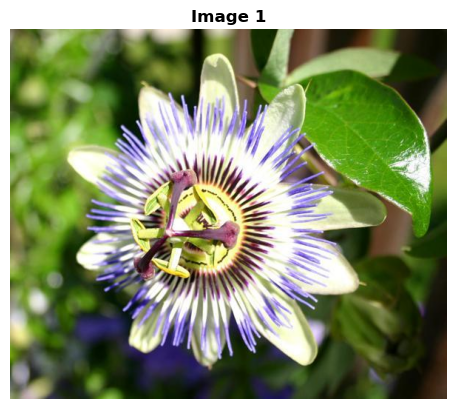

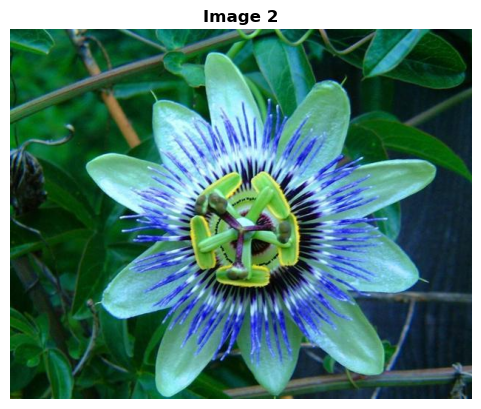

In [20]:
image_1, image_2 = images[0], images[1]
plot_image(image_1, title="Image 1")
plot_image(image_2, title="Image 2")

In [21]:
# Compute similarity using VLAD encoder
similarity = vlad_encoder.similarity_score(image_1, image_2)

print("Similarity score:", similarity)

Similarity score: 0.17133545875549316


In [22]:
# Compute similarity using Fisher Vector encoder
similarity = fisher_encoder.similarity_score(image_1, image_2)

print("Similarity score:", similarity)

Similarity score: 0.09882296566014497
